Image Recognition
===

This notebook will create a convolutional neural network to classify images in either the mnist or cifar-10 datasets.

In [7]:
image_height = 28
image_width = 28

color_channels = 1

model_name = "fashion-mnist"


# Tensorflow and numpy to create the neural network
import tensorflow as tf
import numpy as np

# Matplotlib to plot info to show our results
import matplotlib.pyplot as plt

# OS to load files and save checkpoints
import os

%matplotlib inline

#Other stuff
import seaborn as sns
from tensorflow.python.framework import ops
import os
import cv2
import PIL


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Show one of the images from the training dataset

train_data = x_train
train_labels = np.asarray(y_train, dtype=np.int32)

eval_data = x_test

eval_labels = np.asarray(y_test, dtype=np.int32)


category_names = list(map(str, range(10)))

# TODO: Process mnist data
print (train_data.shape)

train_data = np.reshape(train_data, (-1, 28, 28, 1))

print (train_data.shape)

eval_data = np.reshape(eval_data, (-1, 28, 28, 1))


x_train shape: (60000, 28, 28) y_train shape: (60000,)
(60000, 28, 28)
(60000, 28, 28, 1)


Loading the data
---

This code will load the dataset that you'll use to train and test the model.

The code provided will load the mnist or cifar data from files, you'll need to add the code that processes it into a format your neural network can use.

CIFAR-10
---

Run this cell to load cifar-10 data

Once the data is processed, you have a few variables for the data itself and info about its shape:

### Model Info

- **image_height, image_width** - The height and width of the processed images
- **color_channels** - the number of color channels in the image. This will be either 1 for grayscale or 3 for rgb.
- **model_name** - either "cifar" or "mnist" - if you need to handle anything differently based on the model, check this variable.
- **category_names** - strings for each category name (used to print out labels when testing results)

### Training Data

- **train_data** - the training data images
- **train_labels** - the labels for the training data - the "answer key"

### Evaluation Data

- **eval_data** - Image data for evaluation. A different set of images to test your network's effectiveness.
- **eval_labels** - the answer key for evaluation data.

Building the Neural Network Model
--

Next, you'll build a neural network with the following architecture:

- An input placeholder that takes one or more images.
- 1st Convolutional layer with 32 filters and a kernel size of 5x5 and same padding
- 1st Pooling layer with a 2x2 pool size and stride of 2
- 2nd Convolutional layer with 64 filters and a kernel size of 5x5 and same padding
- 2nd Pooling layer with a 2x2 pool size and stride of 2
- Flatten the pooling layer
- A fully connected layer with 1024 units
- A dropout layer with a rate of 0.4
- An output layer with an output size equal to the number of labels.

In [242]:
# TODO: The neural network
class ConvNet:
    
    def __init__(self, image_height, image_width, channels, num_classes):
        
        self.input_layer = tf.placeholder(dtype = tf.float32, shape=[None, image_height, image_width, channels], name = "inputs")
        print (self.input_layer.shape)
        #input layer input layer shape
        
        
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters = 32, kernel_size=[5,5], padding="same", activation=tf.nn.relu)
        print(conv_layer_1.shape)
        #first conv layer
        
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2,2], strides=2)
        print(pooling_layer_1.shape)
        #pooling to reduce the size, as it's super big, halves the size
        
        
        conv_layer_2 = tf.layers.conv2d(self.input_layer, filters = 64, kernel_size=[5,5], padding="same", activation=tf.nn.relu)
        print(conv_layer_2.shape)
        #nother conv layer that recieves from the pooling, filters doubled because it can?
        
        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size = [2,2], strides = 2)
        print(pooling_layer_2.shape)
        #nother pooling layer
        
        flattened_pooling = tf.layers.flatten(pooling_layer_2)
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        print(dense_layer.shape)
        #lattens the 2d image filters?
        
        dropout = tf.layers.dropout(dense_layer, rate=0.4, training = True)
        #tomatically drops out some neurons to ensure a complete network 
        
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)
        print(outputs)
        #final layer

        #network of neurons set up, now we need hooks to test/train network
        
        self.choice = tf.argmax(outputs, axis=1)
        #finds highest weight element, recieve class predictions
        self.probability = tf.nn.softmax(outputs)
        #return a tensor with decimal probabilities
        
        
        self.labels = tf.placeholder(dtype = tf.float32, name="labels")
        #making the labels
        
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
        #?
        
        #apparently im using softmax and cross entrophy to make the loss function.
        
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels,dtype = tf.int32), depth=num_classes)
        #utilizes one_hot encoding, and logits
        
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
        #one hot encoding utilizes 0s and 1s
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.002)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step = tf.train.get_global_step())
        #optimizer/training operation
        
        
        
CNN = ConvNet(2,28,28,10)

(?, 2, 28, 28)
(?, 2, 28, 32)
(?, 1, 14, 32)
(?, 2, 28, 64)
(?, 1, 14, 64)
(?, 1024)
(?, 10)
Tensor("dense_3/BiasAdd:0", shape=(?, 10), dtype=float32)


The Training Process
---

The cells below will set up and run the training process.

- Set up initial values for batch size, training length.
- Process data into batched datasets to feed into the network.
- Run through batches of training data, update weights, save checkpoints.

In [216]:
# TODO: initialize variables

training_steps = 2000
batch_size = 64

path = "./" + model_name + "-cnn/"

load_checkpoint = True
performance_graph = np.array([])

In [217]:
# TODO: implement the training loop
tf.reset_default_graph()

dataset = tf.data.Dataset.from_tensor_slices((train_data,train_labels)) 
dataset = dataset.shuffle(buffer_size=train_labels.shape[0])
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

dataset_iterator = dataset.make_initializable_iterator()
next_element = dataset_iterator.get_next()


cnn = ConvNet(image_height, image_width,color_channels,10)

saver = tf.train.Saver(max_to_keep=2)

if not os.path.exists(path):
    os.makedirs(path)
    
with tf.Session() as sess:

    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())

    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    for step in range(training_steps):
        current_batch = sess.run(next_element)

        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]

        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
        
        if step % 10 == 0:
            performance_graph = np.append(performance_graph, sess.run(cnn.accuracy))

        if step % 100 == 0 and step > 0:
            current_acc = sess.run(cnn.accuracy)

            print("Accuracy at step" + str(step) + ": " + str(current_acc))
            print ("Saving checkpoint")
            saver.save(sess, path + model_name, step)

    print ("Saving final checkpoint for training session.")
    saver.save(sess, path + model_name, step)

(?, 28, 28, 1)
(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 28, 28, 64)
(?, 14, 14, 64)
(?, 1024)
(?, 10)
INFO:tensorflow:Restoring parameters from ./fashion-mnist-cnn/fashion-mnist-1999
Accuracy at step100: 0.947865
Saving checkpoint
Accuracy at step200: 0.952425
Saving checkpoint
Accuracy at step300: 0.952917
Saving checkpoint
Accuracy at step400: 0.953047
Saving checkpoint
Accuracy at step500: 0.953905
Saving checkpoint
Accuracy at step600: 0.954815
Saving checkpoint
Accuracy at step700: 0.955086
Saving checkpoint
Accuracy at step800: 0.955817
Saving checkpoint
Accuracy at step900: 0.956437
Saving checkpoint
Accuracy at step1000: 0.956615
Saving checkpoint
Accuracy at step1100: 0.957718
Saving checkpoint
Accuracy at step1200: 0.958273
Saving checkpoint
Accuracy at step1300: 0.95879
Saving checkpoint
Accuracy at step1400: 0.959512
Saving checkpoint
Accuracy at step1500: 0.96017
Saving checkpoint
Accuracy at step1600: 0.960754
Saving checkpoint
Accuracy at step1700: 0.961261
Saving checkpoint


Evaluating Performance
---

These cells will evaluate the performance of your network!

Text(0,0.5,'Accuracy')

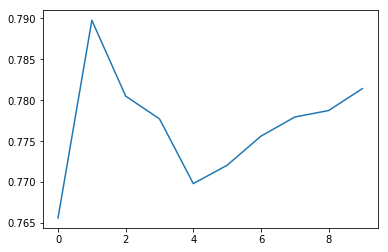

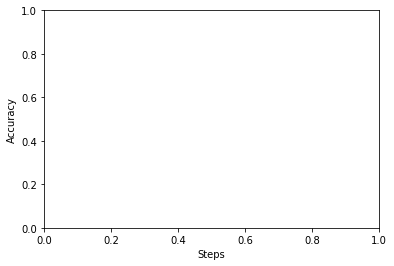

In [207]:
# TODO: Display graph of performance over time

plt.plot(performance_graph)
plt.figure().set_facecolor('white')
plt.xlabel("Steps")
plt.ylabel("Accuracy")

In [28]:
# TODO: Run through the evaluation data set, check accuracy of model

with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
    
    sess.run(tf.local_variables_initializer())
    
    for image, label in zip(eval_data, eval_labels):
        sess.run(cnn.accuracy_op, feed_dict = {cnn.input_layer:[image], cnn.labels:label})
        
    print (sess.run(cnn.accuracy))

INFO:tensorflow:Restoring parameters from ./fashion-mnist-cnn/fashion-mnist-999
0.9048


INFO:tensorflow:Restoring parameters from ./fashion-mnist-cnn/fashion-mnist-1999


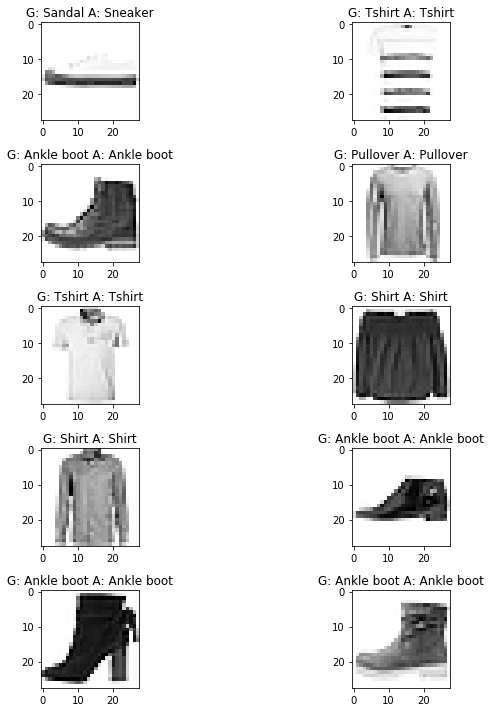

In [245]:
# TODO: Get a random set of images and make guesses for each

label_dict = {
 0: 'Tshirt',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'image',
 9: 'Ankle boot'
}



with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
    
    indexes = np.random.choice(len(eval_data), 10, replace=False)
    

    rows = 5
    cols = 2
     
    fig, axes = plt.subplots(rows, cols, figsize=(10,10))
    fig.patch.set_facecolor('white')
    image_count = 0
     
    for idx in indexes:
        image_count += 1
        sub = plt.subplot(rows,cols,image_count)
        img = eval_data[idx]
        if model_name == "fashion-mnist":
            
            img = img.reshape(28, 28)
        plt.imshow(img, cmap= 'Greys')
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[eval_data[idx]]})
        if model_name == "fashion-mnist":
            guess_name = str(label_dict[guess[0]])
            actual_name = str(label_dict[eval_labels[idx]])
        else:
            guess_name = category_names[guess[0]]
            actual_name = category_names[eval_labels[idx]]
        sub.set_title("G: " + guess_name + " A: " + actual_name)
    plt.tight_layout()

In [29]:
#Testing the neural network

with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
    
    indexes = np.random.choice(len(eval_data), 10, replace=False)


INFO:tensorflow:Restoring parameters from ./fashion-mnist-cnn/fashion-mnist-999


image: <PIL.Image.Image image mode=RGBA size=28x28 at 0x1EF00140DD8>
length: 28
(28, 28)
INFO:tensorflow:Restoring parameters from ./fashion-mnist-cnn/fashion-mnist-1999
[8]
I think it is an image


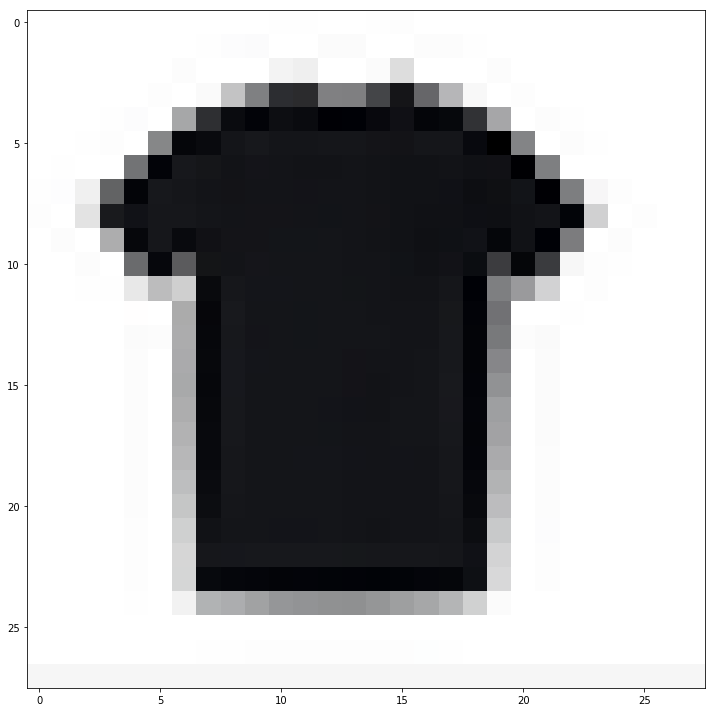

In [247]:
from PIL import Image

#Two variables to edit

actual_name = "shoe"
img = Image.open("blacktshirt.png")

'''
image.thumbnail((28, 28), Image.ANTIALIAS)

print(image.size)
#np.append(arr, np.zeros((28 - arr.shape[0]), arr.shape[1]))
background = Image.new('L', (28,28), (255))
background.paste(
    image, (int((28 - image.size[0]) / 2), int((28 - image.size[1]) / 2))
)
arr = np.array(image)
print(arr.shape)
arr = np.mean(arr, axis=2).reshape(1, 28, 28, 1)
#background.save("sompic.png")
'''


height = 28
width = 28
img = img.resize((height,width), Image.ANTIALIAS)
print("image:",img)
arr = np.array(img)
print("length:",len(arr))
arr = np.mean(arr, axis=2).reshape(1, 28, 28, 1)


print(img.size)

with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
    
    

    rows = 1
    cols = 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(10,10))
    fig.patch.set_facecolor('white')
    
    plt.imshow(img, cmap= 'Greys')
    
    guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:arr})
    print(guess)
    
    print("I think it is an " + label_dict[guess[0]])
    
    guess_name = category_names[guess[0]]
    sub.set_title("G: " + guess_name + " A: " + actual_name)
    plt.tight_layout()
    
    

